# Libraries

In [1]:
pip install emoji

In [2]:
import emoji
import re
import string
from emoji import UNICODE_EMOJI, demojize
from collections import OrderedDict

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix



# Data

In [3]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Ngày 10 tháng 11 .xlsx')
data = data[data['label'] != -2]
data = data.iloc[:len(data)-1] #xóa dòng cuối(dòng độ đồng thuận)
data = data[['comments', 'label']]

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Chia train test/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Chia train test/test.csv')
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Chia train test/val.csv')

In [5]:
train = train[['comments', 'label']]
test = test[['comments', 'label']]
val = val[['comments', 'label']]

In [6]:
train = train[train['label'] != -2]
test = test[test['label'] != -2]
val = val[val['label'] != -2]

#Preprocessing:

In [7]:
stoplist = []
#stoplist = ['mn', 'hs', 'hà', 'nội', 'nhân', 'viên', 'nv', 'ngta', 'tỉnh', 'kiem', 'tra', 'khuyến', 'mãi', 'store', 'online']

In [8]:
def remove_stopwords(sentence):
  words = sentence.split()
  filtered_sentence = []
  for w in words:
    if not w in stoplist:
      filtered_sentence.append(w)
  concat_filter_sentence = ' '.join(filtered_sentence)
  return concat_filter_sentence

In [9]:
def punctuation_clean(s):
  s = s.strip()
  s = s.lower()
  for i in s:
    if i in string.punctuation+'\n':
      s = s.replace(i, ' ')
  return s

def merge_same_character(comment):
  word=[]
  for w in comment.split(): 
    character=[]
    for i in range(len(w)):
      if(i==0):
        character.append(w[i])
      else:
        if(w[i]!= character[int(len(character)-1)]):
          character.append(w[i])
    word.append(''.join(character))
  sentence=' '.join(word)
  return sentence

def removeDupWithOrder(s): 
    return "".join(OrderedDict.fromkeys(s))

def fix_emoji(sentence):
  emojis=[]
  a=sentence.split()
  words=[]
  if len(sentence)==0:
    return sentence
  
  for i in range(len(a)):
    word=[]

    for j in range(len(a[i])):
        if list(a[i])[j] in UNICODE_EMOJI:
          emojis.append(list(a[i])[j])
        else: 
          word.append(list(a[i])[j])

    word_fix=''.join(w for w in word)
    words.append(word_fix)

    while("" in words):
      words.remove("")
    words_fix=' '.join(w for w in words)
    emoji_fix=''.join(e for e in emojis)
    emoji_fix=removeDupWithOrder(emoji_fix)
    emoji_fix_list=list(emoji_fix)
    emoji_fix=' '.join(e for e in emoji_fix_list)
    if words_fix=='':
      return emoji_fix
  
  return words_fix+' '+ emoji_fix

def emoji_to_text(s):
  for x in list(s):
    if (x in UNICODE_EMOJI):
      s = demojize(s)
      s = s.replace(':', ' ')
      break
    else:
      pass
  return s

In [10]:
def data_cleaning(df):
  df.comments = df.comments.apply(punctuation_clean)
  df.comments = df.comments.apply(merge_same_character)
  df.comments = df.comments.apply(fix_emoji)
  df.comments = df.comments.apply(emoji_to_text)
  df.comments = df.comments.apply(remove_stopwords)
  df = df.drop_duplicates()
  df.reset_index(drop=True, inplace=True)
  print(df.shape)
  return df

In [11]:
word_list = pd.read_csv('https://raw.githubusercontent.com/githubbinh/Data-Science-thesis-1/main/word_list.csv')
word_list.columns = ['word', 'count', 'note']
word_list.head(10)

,word,count,note
0,son,10056,NaN
1,màu,8090,NaN
2,hàng,5712,NaN
3,đẹp,5329,NaN
4,giao,3778,NaN
5,rất,3658,NaN
6,shop,3356,NaN
7,gói,3236,NaN
8,không,3168,NaN
9,chất,3094,NaN


In [12]:
word_list.dropna(axis=0, inplace=True)
word_list = word_list[['word', 'note']]
word_list.reset_index(inplace=True)
word_list.shape

(793, 3)

In [13]:
spam_dict = {}
for k, v in spam_dict.items():
  if v == 'spam':
    spam_dict[k] = ''

In [14]:
train = data_cleaning(train)
test = data_cleaning(test)
val = data_cleaning(val)

(9849, 2)
(1267, 2)
(1267, 2)


In [15]:
def remove_spam(s):
  slist = s.split()
  for i in range(len(slist)):
    for k, v in spam_dict.items():
      if slist[i]==k:
        slist[i] = v
  return ' '.join(i for i in slist)

In [16]:
train.comments = train.comments.apply(remove_spam)

In [17]:
X_train = train['comments']
y_train = train['label']
X_test = test['comments']
y_test = test['label']
X_val = val['comments']
y_val = val['label']

### all_data:

In [18]:
data = data_cleaning(data)
data.comments = data.comments.apply(remove_spam)

comments = data['comments']
labels = data['label']

(12228, 2)


#Encoding:
- Sử dụng bert tạo vocabulary
- Sử dụng Countvectorizer

In [19]:
!git clone https://github.com/huggingface/transformers.git

fatal: destination path 'transformers' already exists and is not an empty directory.


In [20]:
# Install the vncorenlp python wrapper
!pip3 install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2020-12-27 14:09:24--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  78.3MB/s    in 0.3s    

2020-12-27 14:09:25 (78.3 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2020-12-27 14:09:25--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200

In [21]:
# Load rdrsegmenter from VnCoreNLP
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') # Load rdrsegmenter from VnCoreNLP
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [22]:
word_list = []
for i in range(len(X_train)): 
  text = X_train[i]
  vocab = rdrsegmenter.tokenize(text)
  for j in vocab:
    for k in j:
      if k not in word_list:
        word_list.append(k)

In [23]:
vocabulary_dict = {}
for i, vocab in enumerate(word_list):
  vocabulary_dict[vocab] = i

###CountVectorizer

In [24]:
cv = CountVectorizer(vocabulary=vocabulary_dict)
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)
X_val = cv.transform(X_val)

In [25]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()


In [26]:
X_train.shape

(9849, 6323)

In [27]:
words = []
for i in cv.vocabulary_:
  words.append(i)

In [28]:
pd.DataFrame(X_train, columns=words)

,màu_son,đánh,nhạt,lên,môi,mình,gần_gần,giống,hồng,cánh_sen,tạm,dùng,được,gói,hàng,cẩn_thận,hastag,dễ_thương_son,chính,hãng,sẽ,ủng_hộ,shop,dài_dài,smiling,_,face,with,3,hearts,_son,mịn,màu,đỏ,nâu,hơi,trầm,xíu,nhưng,rất,...,bịp,như_thế_son,checkcđc,djdjdjsjsjsjsjsisjksdbdjdjdbxjsi,chổi_son,kinh_doanh,này_nọ_son,shoping,photoshop,quá_đà,jealous,dhc,đẩy_son,tay_ấn,bloger,ớt,phát_đạt,jdbdjdnjwbhxbdhdbjebjxbejwnixbdjdb,bet,dinh,rit,nửa_son,phâm,lịm,nk,gian_hàng,chawsb,shoptido,sale5k,thô,thanh_mảnh,ra_gì,tái,107k,dongd,líp,a9,sánh,bới,điệp
0,0,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9844,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9846,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9847,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
len(cv.vocabulary_)

6323

### all_data:

In [30]:
comments = cv.transform(comments)

#Training Models and Use each one to predict val and test

##Naive Bayes model:

In [ ]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### on val:

In [ ]:
naive_bayes_pred_on_val = naive_bayes_model.predict(X_val)

In [ ]:
print(classification_report(y_val, naive_bayes_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       901
         1.0       0.82      0.80      0.81       270
         2.0       0.43      0.25      0.32        96

    accuracy                           0.87      1267
   macro avg       0.72      0.67      0.69      1267
weighted avg       0.85      0.87      0.86      1267



In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_val, naive_bayes_model.predict(X_val), average='macro')))

f1 score: 0.6865


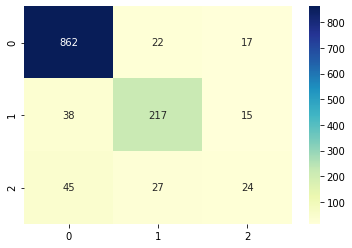

In [ ]:
cm = confusion_matrix(y_val, naive_bayes_model.predict(X_val))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

### on test:

In [ ]:
naive_bayes_pred_on_test = naive_bayes_model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_test, naive_bayes_model.predict(X_test), average='macro')))

f1 score: 0.6363


In [ ]:
print(classification_report(y_test, naive_bayes_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       921
         1.0       0.73      0.79      0.76       253
         2.0       0.31      0.18      0.23        93

    accuracy                           0.85      1267
   macro avg       0.65      0.63      0.64      1267
weighted avg       0.83      0.85      0.84      1267



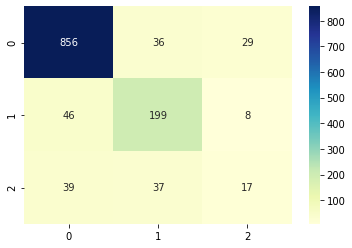

In [ ]:
cm = confusion_matrix(y_test, naive_bayes_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

##Random Forest:

In [ ]:
random_forest_model = RandomForestClassifier(class_weight='balanced')
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### on val:

In [ ]:
random_forest_pred_on_val = random_forest_model.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_val, random_forest_model.predict(X_val), average='macro')))

f1 score: 0.6687


In [ ]:
print(classification_report(y_val, random_forest_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       901
         1.0       0.88      0.78      0.83       270
         2.0       0.78      0.15      0.25        96

    accuracy                           0.88      1267
   macro avg       0.85      0.64      0.67      1267
weighted avg       0.87      0.88      0.86      1267



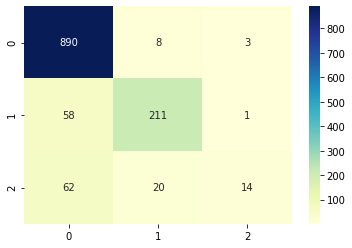

In [ ]:
cm = confusion_matrix(y_val, random_forest_model.predict(X_val))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

### on test:

In [ ]:
random_forest_pred_on_test = random_forest_model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_test, random_forest_model.predict(X_test), average='macro')))

f1 score: 0.6587


In [ ]:
print(classification_report(y_test, random_forest_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       921
         1.0       0.87      0.79      0.82       253
         2.0       0.75      0.13      0.22        93

    accuracy                           0.88      1267
   macro avg       0.83      0.63      0.66      1267
weighted avg       0.87      0.88      0.86      1267



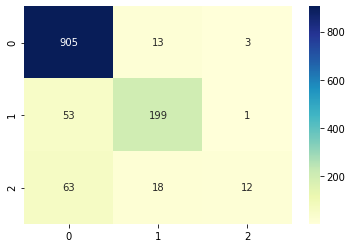

In [ ]:
cm = confusion_matrix(y_test, random_forest_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

## Logistic Regression

In [ ]:

log_model = LogisticRegression(class_weight='balanced', warm_start=True)
log_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

### on val:

In [ ]:
log_reg_pred_on_val = log_model.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_val, log_model.predict(X_val), average='macro')))

f1 score: 0.7195


In [ ]:
print(classification_report(y_val, log_model.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92       901
         1.0       0.78      0.85      0.82       270
         2.0       0.36      0.51      0.42        96

    accuracy                           0.85      1267
   macro avg       0.70      0.75      0.72      1267
weighted avg       0.87      0.85      0.86      1267



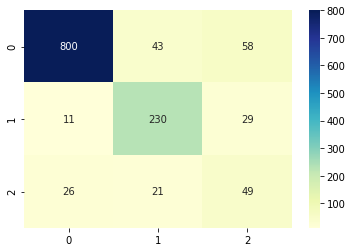

In [ ]:
cm = confusion_matrix(y_val, log_model.predict(X_val))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

### on test:

In [ ]:
log_reg_pred_on_test = log_model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_test, log_model.predict(X_test), average='macro')))

f1 score: 0.6951


In [ ]:
print(classification_report(y_test, log_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       921
         1.0       0.77      0.81      0.79       253
         2.0       0.30      0.56      0.39        93

    accuracy                           0.83      1267
   macro avg       0.68      0.74      0.70      1267
weighted avg       0.87      0.83      0.85      1267



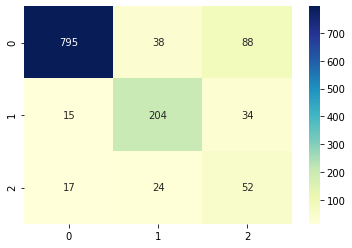

In [ ]:
cm = confusion_matrix(y_test, log_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
SVM = SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)
SVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### on val:

In [ ]:
SVM_pred_on_val = SVM.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_val, SVM.predict(X_val), average='macro')))

f1 score: 0.7197


In [ ]:
print(classification_report(y_val, SVM_pred_on_val))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       901
         1.0       0.75      0.88      0.81       270
         2.0       0.39      0.46      0.42        96

    accuracy                           0.86      1267
   macro avg       0.70      0.74      0.72      1267
weighted avg       0.88      0.86      0.87      1267



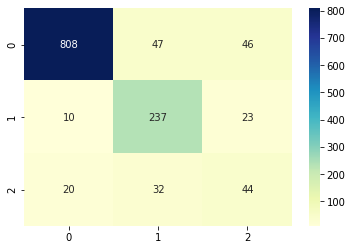

In [ ]:
cm = confusion_matrix(y_val, SVM_pred_on_val)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

### on test:

In [ ]:
SVM_pred_on_test = SVM.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
print('f1 score: {:.4f}'.format(f1_score(y_test, SVM.predict(X_test), average='macro')))

f1 score: 0.6978


In [ ]:
print(classification_report(y_test, SVM_pred_on_test))

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92       921
         1.0       0.69      0.90      0.78       253
         2.0       0.37      0.43      0.40        93

    accuracy                           0.84      1267
   macro avg       0.68      0.73      0.70      1267
weighted avg       0.87      0.84      0.85      1267



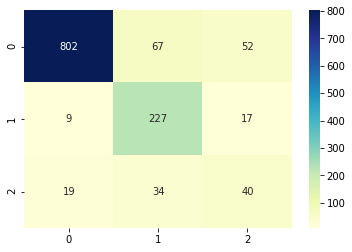

In [ ]:
cm = confusion_matrix(y_test, SVM_pred_on_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

##Try Fully Connected Net:


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train), y_train)

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
FCN_model = Sequential()
FCN_model.add(Dense(256, input_shape=(X_train.shape[1], ), activation='relu'))
FCN_model.add(Dropout(0.1))
FCN_model.add(Dense(64, activation='relu'))
FCN_model.add(Dropout(0.2))
FCN_model.add(Dense(32, activation='relu'))
FCN_model.add(Dropout(0.2))
FCN_model.add(Dense(16, activation='relu'))
FCN_model.add(Dropout(0.3))
FCN_model.add(Dense(3, activation='softmax'))
FCN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1618944   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

In [ ]:
FCN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
FCN_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50, class_weight=dict(enumerate(class_weights)))

Epoch 1/50
308/308 [==============================] - 4s 6ms/step - loss: 0.9329 - accuracy: 0.6996 - val_loss: 0.4792 - val_accuracy: 0.7948
Epoch 2/50
308/308 [==============================] - 2s 5ms/step - loss: 0.5426 - accuracy: 0.8273 - val_loss: 0.4021 - val_accuracy: 0.8343
Epoch 3/50
308/308 [==============================] - 1s 5ms/step - loss: 0.3972 - accuracy: 0.8738 - val_loss: 0.4579 - val_accuracy: 0.8256
Epoch 4/50
308/308 [==============================] - 1s 5ms/step - loss: 0.2785 - accuracy: 0.9129 - val_loss: 0.4301 - val_accuracy: 0.8627
Epoch 5/50
308/308 [==============================] - 2s 5ms/step - loss: 0.1961 - accuracy: 0.9387 - val_loss: 0.5228 - val_accuracy: 0.8792
Epoch 6/50
308/308 [==============================] - 2s 5ms/step - loss: 0.1215 - accuracy: 0.9563 - val_loss: 0.6712 - val_accuracy: 0.8595
Epoch 7/50
308/308 [==============================] - 2s 5ms/step - loss: 0.0992 - accuracy: 0.9742 - val_loss: 0.6537 - val_accuracy: 0.8777
Epoch 

In [ ]:
from sklearn.metrics import f1_score
print('val f1 score: {:.4f}'.format(f1_score(np.argmax(y_val, axis=-1), np.argmax(FCN_model.predict(X_val), axis=-1), average='macro')))
print('test f1 score: {:.4f}'.format(f1_score(np.argmax(y_test, axis=-1), np.argmax(FCN_model.predict(X_test), axis=-1), average='macro')))

val f1 score: 0.7398
test f1 score: 0.7170


In [ ]:
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(FCN_model.predict(X_test), axis=-1)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       921
           1       0.82      0.83      0.82       253
           2       0.39      0.38      0.38        93

    accuracy                           0.88      1267
   macro avg       0.72      0.72      0.72      1267
weighted avg       0.88      0.88      0.88      1267



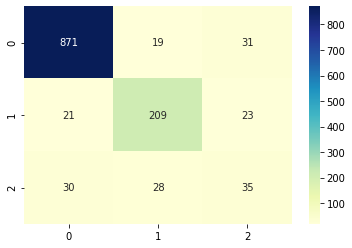

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(FCN_model.predict(X_test), axis=-1))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

In [ ]:
FCN_pred_on_val = np.argmax(FCN_model.predict(X_val), axis=-1)
FCN_pred_on_test = np.argmax(FCN_model.predict(X_test), axis=-1)

# SAVE models:

In [ ]:
import joblib
import pickle

In [ ]:
joblib.dump(naive_bayes_model, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/naive_bayes_model.h5')
pickle.dump(naive_bayes_model, open('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/naive_bayes_model.pkl', 'wb'))

In [ ]:
joblib.dump(random_forest_model, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/random_forest_model.h5')
pickle.dump(random_forest_model, open('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/random_forest_model.pkl', 'wb'))

In [ ]:
joblib.dump(log_model, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/log_model.h5')
pickle.dump(log_model, open('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/log_model.pkl', 'wb'))

In [ ]:
joblib.dump(SVM, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/SVM.h5')
pickle.dump(SVM, open('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/SVM.pkl', 'wb'))
joblib.dump(SVM, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/SVM.joblib')

['/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/SVM.joblib']

In [ ]:
FCN_model.save('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_model.h5')

In [ ]:
from keras.models import model_from_yaml

# serialize model to YAML
model_yaml = FCN_model.to_yaml()
with open("/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
FCN_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_weights.h5")
print("Saved model to disk")
 
# later...
 
# load YAML and create model
yaml_file = open('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
FCN_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
FCN_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
FCN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Saved model to disk
Loaded model from disk


### Save Countvectorizer:

In [ ]:
joblib.dump(cv, '/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/cv.h5')

['/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/cv.h5']

# Load models:

In [31]:
from keras.models import load_model
BiLSTM_model = load_model('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/BiLSTM_model.h5')

In [32]:
import joblib
naive_bayes_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/naive_bayes_model.h5')
random_forest_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/random_forest_model.h5')
log_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/log_model.h5')
SVM = joblib.load('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/SVM.h5')
FCN_model = load_model('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/SAVED_MODELS/FCN_model.h5')

# Ensample models(Majority Voting):

### on val:

In [34]:
naive_bayes_pred_on_val = naive_bayes_model.predict(X_val)
random_forest_pred_on_val = random_forest_model.predict(X_val)
log_reg_pred_on_val = log_model.predict(X_val)
SVM_pred_on_val = SVM.predict(X_val)
FCN_pred_on_val = np.argmax(FCN_model.predict(X_val), axis=-1)
BiLSTM_pred_on_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/MODELs_and_ERRORs/data_to_ensemble /predicted_val_BiLSTM.csv')

In [37]:
BiLSTM_pred_on_val = BiLSTM_pred_on_val['predicted_val_BiLSTM']

In [40]:
BiLSTM_pred_on_val = np.array(BiLSTM_pred_on_val)

In [47]:
val_results = pd.DataFrame([SVM_pred_on_val, naive_bayes_pred_on_val, FCN_pred_on_val, log_reg_pred_on_val, random_forest_pred_on_val, BiLSTM_pred_on_val])

In [48]:
ensampled_results = []
for i in range(len(val_results.columns)):
  temp = val_results[i].mode().values[0]
  ensampled_results.append(temp)

In [67]:
from sklearn.metrics import f1_score
print('val f1 score: {:.4f}'.format(f1_score(np.array(ensampled_results), np.array(y_val), average='macro')))

val f1 score: 0.7571


In [55]:
print(classification_report(np.array(ensampled_results), np.array(y_val)))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       918
         1.0       0.86      0.87      0.87       268
         2.0       0.42      0.49      0.45        81

    accuracy                           0.90      1267
   macro avg       0.75      0.77      0.76      1267
weighted avg       0.91      0.90      0.90      1267



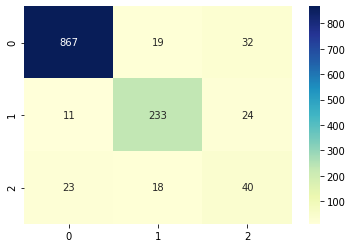

In [56]:
cm = confusion_matrix(np.array(ensampled_results), np.array(y_val))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu');

### on test:

In [57]:
naive_bayes_pred_on_test = naive_bayes_model.predict(X_test)
random_forest_pred_on_test = random_forest_model.predict(X_test)
log_reg_pred_on_test = log_model.predict(X_test)
SVM_pred_on_test = SVM.predict(X_test)
FCN_pred_on_test = np.argmax(FCN_model.predict(X_test), axis=-1)
BiLSTM_pred_on_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/MODELs_and_ERRORs/data_to_ensemble /predicted_test_BiLSTM.csv')

In [58]:
BiLSTM_pred_on_test = BiLSTM_pred_on_test['predicted_test_BiLSTM']
BiLSTM_pred_on_test = np.array(BiLSTM_pred_on_test)

In [59]:
test_results = pd.DataFrame([SVM_pred_on_test, naive_bayes_pred_on_test, FCN_pred_on_test, log_reg_pred_on_test, random_forest_pred_on_test, BiLSTM_pred_on_test])

In [60]:
test_ensampled_results = []
for i in range(len(test_results.columns)):
  temp = test_results[i].mode().values[0]
  test_ensampled_results.append(temp)

In [68]:
print('val f1 score: {:.4f}'.format(f1_score(np.array(test_ensampled_results), np.array(y_test), average='macro')))

val f1 score: 0.7452


In [63]:
print(classification_report(np.array(test_ensampled_results), np.array(y_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       928
         1.0       0.87      0.84      0.85       261
         2.0       0.40      0.47      0.43        78

    accuracy                           0.90      1267
   macro avg       0.74      0.75      0.75      1267
weighted avg       0.90      0.90      0.90      1267



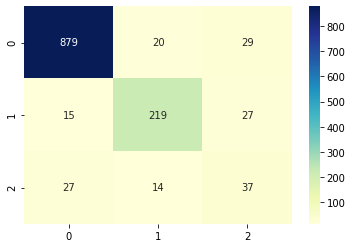

In [65]:
cm = confusion_matrix(np.array(test_ensampled_results), np.array(y_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu');

# Predict and determine wrong predictions for all_data

In [ ]:
naive_bayes_pred = naive_bayes_model.predict(comments)
random_forest_pred = random_forest_model.predict(comments)
logistic_regression_pred = log_model.predict(comments)
SVM_pred = SVM.predict(comments.A)
FCN_pred = np.argmax(FCN_model.predict(comments), axis=-1) 

In [ ]:
Error_Analysis = pd.DataFrame(data={'comments': data['comments'],
                                    'labels':labels, 
                                    'naive_bayes_pred': naive_bayes_pred,
                                    'random_forest_pred': random_forest_pred, 
                                    'logistic_regression_pred':logistic_regression_pred,
                                    'SVM_pred': SVM_pred,
                                    'FCN_pred':FCN_pred})



In [ ]:
Error_Analysis['naive_bayes_pred'] = Error_Analysis['naive_bayes_pred'].astype('int')
Error_Analysis['random_forest_pred'] = Error_Analysis['random_forest_pred'].astype('int')
Error_Analysis['logistic_regression_pred'] = Error_Analysis['logistic_regression_pred'].astype('int')
Error_Analysis['FCN_pred'] = Error_Analysis['FCN_pred'].astype('int')
Error_Analysis['labels'] = Error_Analysis['labels'].astype('int')
Error_Analysis['SVM_pred'] = Error_Analysis['SVM_pred'].astype('int')

In [ ]:
Error_Analysis.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/predictions.csv')

In [ ]:
false_naive_bayes_pred = Error_Analysis[Error_Analysis['naive_bayes_pred'] != Error_Analysis['labels']][['comments', 'labels', 'naive_bayes_pred']]
false_random_forest_pred = Error_Analysis[Error_Analysis['random_forest_pred'] != Error_Analysis['labels']][['comments', 'labels', 'random_forest_pred']]
false_log_reg_pred = Error_Analysis[Error_Analysis['logistic_regression_pred'] != Error_Analysis['labels']][['comments', 'labels', 'logistic_regression_pred']]
false_FCN_pred = Error_Analysis[Error_Analysis['FCN_pred'] != Error_Analysis['labels']][['comments', 'labels', 'FCN_pred']]
false_SVM_pred = Error_Analysis[Error_Analysis['SVM_pred'] != Error_Analysis['labels']][['comments', 'labels', 'SVM_pred']]

In [ ]:
false_naive_bayes_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/false_naive_bayes_pred.csv')
false_random_forest_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/false_random_forest_pred.csv')
false_log_reg_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/false_log_reg_pred.csv')
false_FCN_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/false_FCN_pred.csv')
false_SVM_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Đồ án KHDL1/Phân tích lỗi/false_SVM_pred.csv')

# To predict a sentence

## Preprocess a sentence:

In [ ]:
def preprocess_sentence(sentence):
  sentence = punctuation_clean(sentence)
  sentence = merge_same_character(sentence)
  sentence = fix_emoji(sentence)
  sentence = emoji_to_text(sentence)
  sentence = remove_stopwords(sentence)
  return sentence

## Encode sentence:

In [ ]:
def encode_sentence(sentence):
  return cv.transform([sentence])

## Predict:

In [ ]:
def predict(sentence):
  sentence = preprocess_sentence(sentence)
  sentence = encode_sentence(sentence)

  naive_bayes_pred = naive_bayes_model.predict(sentence)[0]
  random_forest_pred = random_forest_model.predict(sentence)[0]
  log_reg_pred = log_model.predict(sentence)[0]
  SVM_pred = SVM.predict(sentence.A)[0]
  FCN_pred = np.argmax(FCN_model.predict(sentence), axis=-1)[0]
  result = pd.DataFrame([naive_bayes_pred, random_forest_pred, log_reg_pred, SVM_pred, FCN_pred]).mode()[0][0]
  return result

# Make a prediction

In [ ]:
predict('cũng được')

0.0

In [ ]:
predict('tạm được')

2.0

In [ ]:
predict('không được')

1.0